# ※ Quiz
```
naver open API를 활용하여 네이버지식인 '전주여행'과 '경주여행' 검색 
-> 품사태깅 백업, 명사만 추출(re ?) 
-> 빈도분석(DataFrame) 
-> 빈도 시각화(워드클라우드, Text) 
-> Word2Vec 
```

# 1. 네이버 open API를 활용하여 검색 추출
- 검색어, no, title, description, title + '' + description(total_text)

In [2]:
import pandas as pd
from dotenv import load_dotenv
import os
import requests
from bs4 import BeautifulSoup
import re
from html import unescape

In [ ]:


client_id = os.getenv('Client_ID')
client_secret = os.getenv('Client_Secret')
headers = {'X-Naver-Client-Id' : client_id, "X-Naver-Client-Secret" : client_secret}
dic={'query':[],'No':[],'title':[],'link':[],'description':[],'total_text':[]}
file_name = 'data/경주_전주.csv'
i=1
for query in ['전주여행', '경주여행']:
    for start in range(5):
        url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start+1}'
        response = requests.get(url, headers=headers)
        items = response.json()['items']

        for item in items:
            title = item.get('title').replace('<b>','').replace('</b>','')
            description = item.get('description').replace('<b>','').replace('</b>','')
            description = unescape(description) 
            description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
            description = re.sub('\s+', ' ', description)
            text = title + '' + description
            dic['query'].append(query)
            dic['No'].append(start*100+1+i)
            dic['title'].append(title)
            dic['link'].append(item.get('link'))
            dic['description'].append(description)
            dic['total_text'].append(text)
            i+=1
            
df = pd.DataFrame(dic)
df.to_csv('data/전경주.csv')

# 2. 품사태깅 백업, 명사만 추출

In [8]:
from konlpy.tag import Hannanum
from mecab import MeCab
import pandas as pd
df = pd.read_csv('data/전경주.csv', sep=',')
analyzer = MeCab()
stopwords = ['전주','경주','여행']
select_pos = ['NC','NQ','NB'] 
df_list = df[['query','No','total_text']].values.tolist()

postagged_lst = []
for i, row in enumerate(df_list):
    query = row[0]
    no = row[1]
    text = row[2]
    text_pos = analyzer.pos(text)
    # analyzer가 MeCab이 아닐 경우 시간이 좀 걸려서 250개마다 로그 출력
#     if i%250==0:
#         print("{}의 {}번째 품사태깅 결과 {}개 저장중".format(query, 
#                                                 no, 
#                                                 len(text_pos), end='\n\n'))
    for token, pos in text_pos:
        # if token not in stopwords and pos in select_pos: 라고 하면 명사만 추출
        if token not in stopwords: # 모든 품사를 우선 다 넣고 나중에 빼려면
            postagged_lst.append({'query':query,
                                 'No':no,
                                 'token':token,
                                 'pos':pos})
df_postagged = pd.DataFrame(postagged_lst)
df_postagged.to_csv('data/전경주_pos.csv')

In [11]:
df_postagged = pd.read_csv('data/전경주_pos.csv')
df_nouns = df_postagged.loc[df_postagged['pos'].isin(['NNP', 'NNG']),
                            ['query', 'token','pos']]
df_nouns.to_csv('data/전경주_nouns.csv')

# 3. 빈도분석

In [18]:
df_nouns = pd.read_csv('data/전경주_nouns.csv')
df_nouns.groupby('query', as_index=False)['token'].value_counts()

,query,token,count
0,경주여행,코스,446
1,경주여행,추천,386
2,경주여행,계획,154
3,경주여행,곳,146
4,경주여행,숙소,139
...,...,...,...
1010,전주여행,감성,1
1011,전주여행,용권,1
1012,전주여행,용추,1
1013,전주여행,카페이,1


# 4. 빈도시각화

(-0.5, 555.5, 274.5, -0.5)

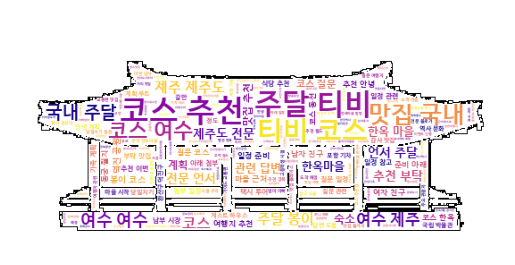

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import cv2
mask = cv2.imread('data/korea-house-black-fill.png')
wordc = WordCloud(font_path='C:\\Windows\\Fonts\\한컴 고딕\\Hancom Gothic Bold.ttf',
                  colormap='plasma',
                  background_color='white',
                  mask=mask,
                  contour_color='black',
                  contour_width=1,
                  min_font_size=3)
nouns = [token for token in df_nouns['token'] if len(token) > 1]
text = ' '.join(nouns)
wordc.generate(text)
plt.imshow(wordc)
plt.axis('off')

# 5. Word2Vec

In [61]:
from gensim.models import Word2Vec
from mecab import MeCab
mecab = MeCab()

df_total_text = pd.read_csv('data/전경주.csv')
total_text = [mecab.nouns(text) for text in df_total_text['total_text']]
model = Word2Vec(total_text,      # 학습데이터 2차원
                 window=10, # 각 단어의 좌우 10개 단어를 학습 컨텐츠로 사용
                 min_count=2, # 학습데이터에서 2회 이상 등장한 단어만 학습
                 workers=-1  # 병렬철 core수. -1 : 모든 core(CPU core) 사용
                 )


In [67]:
model.wv.most_similar('경주')

[('중순', 0.3641005754470825),
 ('소록', 0.23504950106143951),
 ('사용', 0.22424650192260742),
 ('금액', 0.21925438940525055),
 ('저번', 0.21867415308952332),
 ('고요', 0.21855027973651886),
 ('의', 0.21632219851016998),
 ('관람', 0.2159893959760666),
 ('가요', 0.21469099819660187),
 ('천마총', 0.2134207934141159)]